In [1]:
# imports

import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# helper functions

def split(X, y, ratio):    
    test_split = int(len(X) * ratio)
    
    X_train, y_train = X[:test_split], y[:test_split]
    X_test, y_test = X[test_split:], y[test_split:]
    return X_train, y_train, X_test, y_test

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=(12,7)) 
    ax = fig.add_subplot(111)
    ax.plot(true_data, 'b-', label='True Data')
    plt.plot(predicted_data, 'r^', label='Prediction')
    plt.xlabel('Time (s)')
    plt.ylabel('Activation')
    plt.legend()
    plt.show()
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(12,7)) 
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [3]:
# globals

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
EXTERNALS_PATH = 'data/externals'

In [4]:
# train-test split

X = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'X.npy'))
y = np.load(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y.npy'))
X_train, y_train, X_test, y_test = split(X, y, ratio=0.8)

## Model: 3 layers; 1 training epoch

In [5]:
from keras.models import load_model
model = load_model('../saved_models/01052019-092342-e1.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(f'Train Score: {trainScore} MSE ({math.sqrt(trainScore)} RMSE)')

testScore = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Score: {testScore} MSE ({math.sqrt(testScore)} RMSE)')

Train Score: 0.006708766659756012 MSE (0.08190706111048066 RMSE)
Train Score: 3.605395133169648e-06 MSE (0.0018987878062515695 RMSE)


In [7]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [8]:
# how many activations in actual testing set
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

array([[0.000000e+00, 5.824563e+06],
       [1.000000e+00, 2.100000e+01]])

In [9]:
# how many unique model's output values 
y_test_pred = np.reshape(y_test_pred, (y_test_pred.size,))
unique, counts = np.unique(y_test_pred, return_counts=True)
np.asarray((unique, counts)).T

array([[2.83986310e-06, 5.82448400e+06],
       [5.11099825e-06, 2.00000000e+01],
       [5.55253246e-06, 2.00000000e+01],
       [6.64734034e-06, 2.00000000e+01],
       [8.57259147e-06, 2.00000000e+01],
       [9.02726970e-06, 2.00000000e+01]])

In [10]:
# interpreting LSTM output values

y_test_pred[y_test_pred==2.83986310e-06]=0
y_test_pred[y_test_pred!=0]=1
y_test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

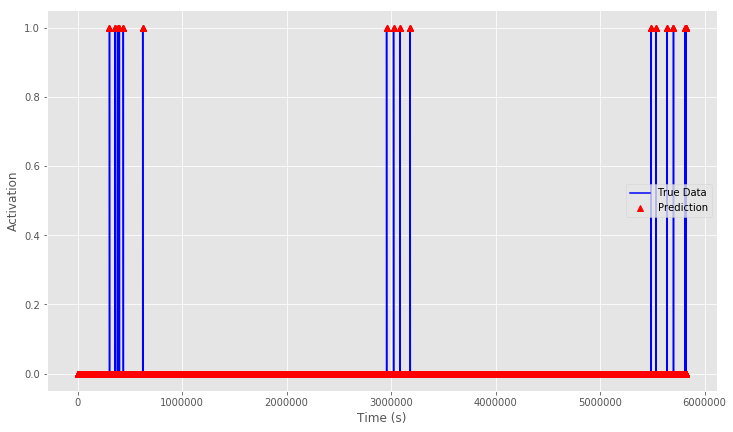

In [11]:
plot_results(predicted_data=y_test_pred, 
             true_data=y_test)

## Model: 5 layers; 10 training epochs

In [21]:
from keras.models import load_model
model = load_model('../saved_models/29052019-164232-e10.h5')

In [22]:
y_train_pred_10 = model.predict(X_train)
y_test_pred_10 = model.predict(X_test)

In [23]:
# how many unique model's output values 
y_test_pred_10 = np.reshape(y_test_pred_10, (y_test_pred_10.size,))
unique, counts = np.unique(y_test_pred_10, return_counts=True)
np.asarray((unique, counts)).T

array([[1.21673493e-05, 5.82448400e+06],
       [1.52176805e-03, 2.00000000e+01],
       [1.84416212e-03, 2.00000000e+01],
       [1.91396230e-03, 2.00000000e+01],
       [1.91468524e-03, 2.00000000e+01],
       [1.91875699e-03, 2.00000000e+01]])

In [24]:
# interpreting LSTM output values

y_test_pred_10[y_test_pred_10==1.21673493e-05]=0
y_test_pred_10[y_test_pred_10!=0]=1
y_test_pred_10

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [26]:
# save the output for the further evaluation
np.save(os.path.join(PROJ_ROOT, EXTERNALS_PATH, 'y_test_pred_10.npy'), y_test_pred_10)

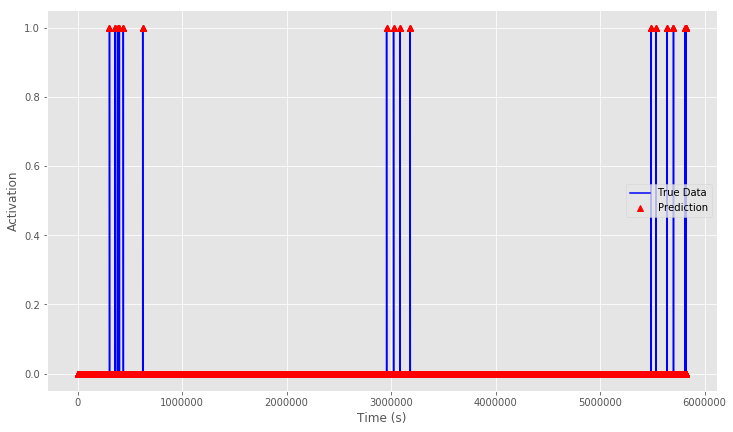

In [27]:
plot_results(predicted_data=y_test_pred_10, 
             true_data=y_test)

# Predicting future sequnces 

## Model: 5 layers; 10 training epochs

In [6]:
from keras.models import load_model
model = load_model('../saved_models/29052019-164232-e10.h5')

In [7]:
def predict_sequences_multiple(data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [9]:
y_test_pred_10_seq = predict_sequences_multiple(data=X_test, 
                                                window_size=5, 
                                                prediction_len=10)